In [1]:
!pip install yfinance


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pickle
import yfinance as yf

In [3]:
def LagguerreRSI(data, gamma):
    # Create base data structures
    out = []
    l =[np.zeros(4), [data.iloc[0]]*4]
    cu =np.zeros(3)
    cd =np.zeros(3)
    for i in data.index:
        # Different calculation for if it is the first price value
        l[0][0] = ((1-gamma)*data[i]) + (gamma*l[1][0])
        l[0][1] = ((-gamma)*l[0][0]) + l[1][0] + (gamma*l[1][1])
        l[0][2] = ((-gamma)*l[0][1]) + l[1][1] + (gamma*l[1][2])
        l[0][3] = ((-gamma)*l[0][2]) + l[1][2] + (gamma*l[1][3])
        # Calculate the Count Up and Count Down   
        cu[0] = l[0][0] - l[0][1] if l[0][0] >= l[0][1] else 0
        cu[1] = cu[0] + (l[0][1] - l[0][2]) if l[0][1] >= l[0][2] else cu[0]
        cu[2] = cu[1] + (l[0][2] - l[0][3]) if l[0][2] >= l[0][3] else cu[1]
        
        cd[0] = 0 if l[0][0] >= l[0][1] else l[0][1] - l[0][0]
        cd[1] = cd[0] if l[0][1] >= l[0][2] else cd[0] + (l[0][2] -l[0][1])
        cd[2] = cd[1] if l[0][2] >= l[0][3] else cd[1] + (l[0][3] - l[0][2])
        # Calculate the RSI from the final CU and CD
        out.append(cu[2]/(cu[2] + cd[2]) if (cu[2] + cd[2]) != 0 else 0)
        # Store the Laguerre values to another list so previous values can be reffed
        l[1] = l[0]
        l[0] = np.zeros(4)
                
    return out


In [102]:
((26+48)*5)/60

6.166666666666667

In [101]:
(4*60)/5

48.0

In [4]:
data = pd.read_csv('forex.csv')

In [5]:
def calculate_k(df):
    close = df.Close
    highest_high = df.High.rolling(10).max()
    lowest_low = df.Low.rolling(10).min()
    df['per_k_10'] = (close - lowest_low)/(highest_high-lowest_low)
    return df

def calculate_d(df):
    df['per_d_10'] = df['per_k_10'].rolling(10).mean()
    return df

def stoichastic_osc(df):
    df_new = calculate_k(df)
    df_new = calculate_d(df_new)
    return df_new

def macd_signal(df):
    exp1 = df.Close.ewm(span=12, adjust=False).mean()
    exp2 = df.Close.ewm(span=26, adjust=False).mean()
    df['macd'] = exp1-exp2
    df['macd_signal'] = df.macd.ewm(span=9, adjust=False).mean()
    return df

def MinMax(x):
    xt = (x-min(x))/(max(x)-min(x))
    return xt.fillna(0)

In [6]:
def MinMax(x):
    xt = (x-min(x))/(max(x)-min(x))
    return xt.fillna(0)

curDict = {}
for c in tqdm(data.Symbol.tolist()):
    ticker = yf.Ticker(c)
    tmp = ticker.history(period='10d', interval='5m')
    cols = ['Open','High', 'Low', 'Close']
    tmp = tmp[cols] 

    # min_c = tmp.apply(min, axis=0).to_dict()
    # max_c = tmp.apply(max, axis=0).to_dict()
    # tmp = tmp.apply(MinMax, axis=0)
    tmp['time'] = (tmp.index.hour*60 + tmp.index.minute) /1440
    tmp['sma'] = tmp.Close.rolling(20).mean()
    tmp = stoichastic_osc(tmp)
    tmp = macd_signal(tmp)
    std = tmp.Close.rolling(20).std()
    tmp['upper_bol'] = tmp['sma'] + (2*std)
    tmp['lower_bol'] = tmp['sma'] - (2*std)
    # tmp['z_bol'] = (tmp.Close - tmp['sma'])/(std*2)
    tmp['RSI_point8'] = tmp[['Close']].apply(LagguerreRSI, gamma = 0.8)
    price_cols = ['Open','High', 'Low', 'Close', 'sma',  'upper_bol', 'lower_bol']
    # for col in price_cols:
    #   tmp[col] = (tmp[col]-tmp[price_cols].values.min())/(tmp[price_cols].values.max()-tmp[price_cols].values.min())
    curDict[c] =  tmp.dropna()

100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


In [7]:
price_cols = ['Open','High', 'Low', 'Close', 'sma',  'upper_bol', 'lower_bol']
macd_cols = ['macd','macd_signal']
osc_cols = ['per_k_10', 'per_d_10']
non_scaled_cols = ['time','RSI_point8']


In [8]:
df = curDict[c]

In [9]:
all_cols = df.columns

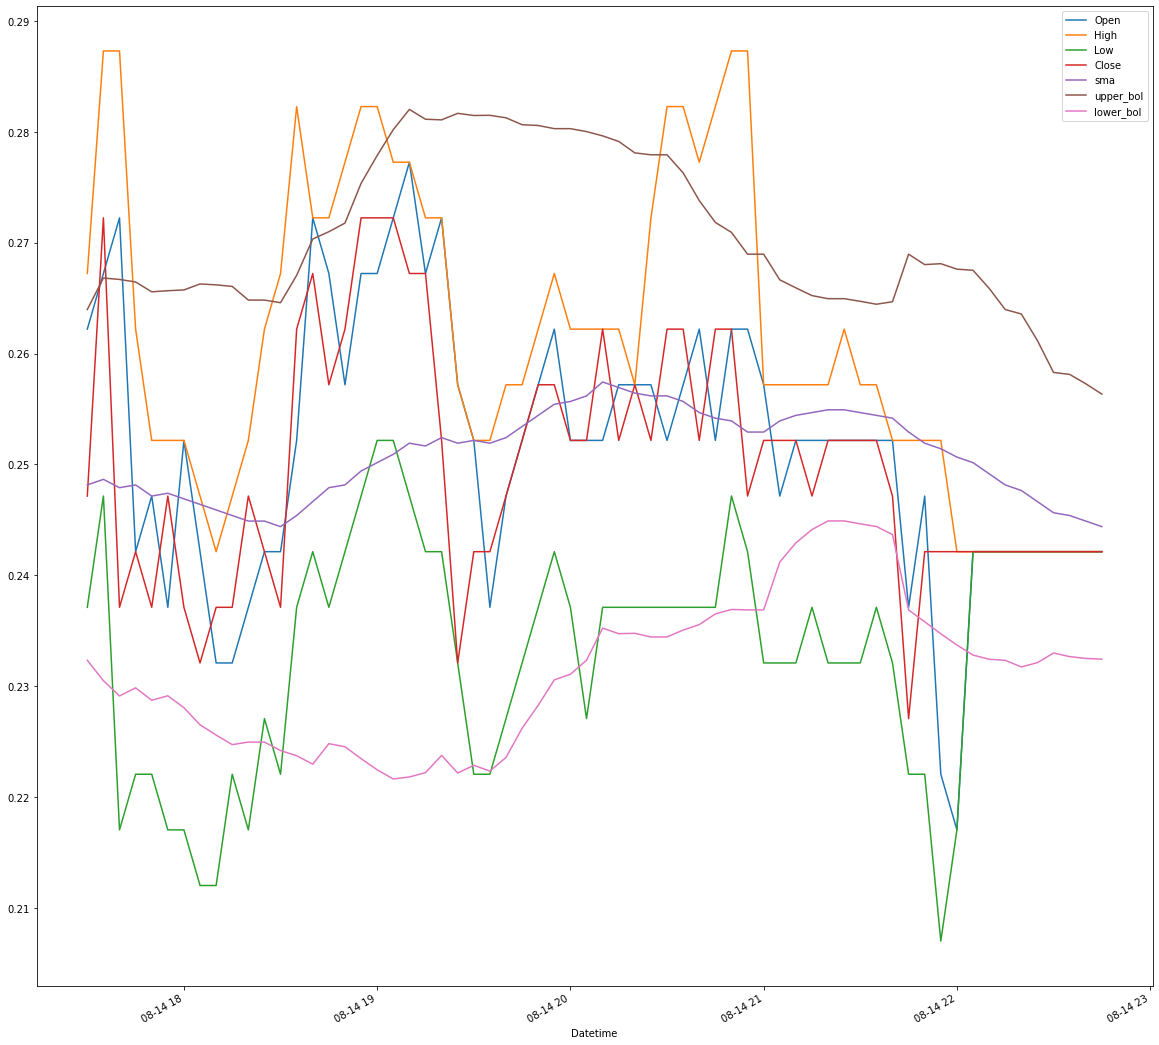

In [10]:
((df[price_cols]-df[price_cols].values.min())/(df[price_cols].values.max()-df[price_cols].values.min()))[-64:].plot(figsize= (20,20))

In [5]:
price_cols = ['Open','High', 'Low', 'Close', 'sma',  'upper_bol', 'lower_bol']
macd_cols = ['macd','macd_signal']
osc_cols = ['per_k_10', 'per_d_10']
non_scaled_cols = ['time','RSI_point8']
seq_length = 128

In [250]:

def MinMax(x):
    xt = (x-min(x))/(max(x)-min(x))
    return xt.fillna(0)

def ztransform(x):
    return (x-np.mean(x))/np.std(x)
x = []
y = []
minmax = {'min':[],'max':[]}
for c in tqdm(data.Symbol.tolist()):
    df = curDict[c]
    # df['time'] = (df.index.hour*60 + df.index.minute) /1440
    for i in range(len(df)-(seq_length*2)):
    # for i in range(int(len(df) / seq_length)):
        # start_idx = i*seq_length
        obs = df.iloc[i:i+seq_length*2]
        if obs.values.shape[0] == seq_length*2:
            price_obs = obs[price_cols].values
            price_min = price_obs.min()
            price_max = price_obs.max()
            price_obs = (price_obs - price_min)/(price_max-price_min)
            macd_obs = obs[macd_cols].values
            macd_min = macd_obs.min()
            macd_max = macd_obs.max()
            macd_obs = (macd_obs - macd_min)/(macd_max-macd_min)
            osc_obs = obs[osc_cols].values
            osc_min = osc_obs.min()
            osc_max = osc_obs.max()
            osc_obs = (osc_obs - osc_min)/(osc_max-osc_min)
            other_obs = obs[non_scaled_cols].values
            obs = np.concatenate([price_obs, macd_obs,osc_obs,other_obs], axis=1)
            # print(obs.shape)
            minmax['min'].append({'price':price_min, 'macd':macd_min, 'osc':osc_min})
            minmax['max'].append({'price':price_max, 'macd':macd_max, 'osc':osc_max})


            y.append(obs[seq_length:,:])
            x.append(obs[:seq_length,:])
              # if fore.High.max()>obs.High.max(): 
              #     y.append([0,0,1])
              # elif fore.Low.min()<obs.Low.min(): 
              #     y.append([1,0,0])
              # else:
              #     y.append([0,1,0])
        

            

100%|██████████| 28/28 [03:55<00:00,  8.42s/it]


In [251]:
import pickle

with open('training_set.pkl', 'wb') as f:
    pickle.dump({'x':np.array(x),'y':np.array(y)},f)

with open('training_set_raw.pkl', 'wb') as f:
    pickle.dump(curDict,f)

In [252]:
del x, y

In [17]:
import pickle

with open('training_set.pkl', 'rb') as f:
    trainDict = pickle.load(f)
    
with open('training_set_raw.pkl', 'rb') as f:
    curDict = pickle.load(f)

In [18]:
from sklearn.model_selection import train_test_split
X = np.array(trainDict['x'])
Y = np.array(trainDict['y'])
X_train, X_test, Y_train, Y_test = train_test_split(X.reshape(X.shape[0], X.shape[1], X.shape[2]), Y, test_size=0.3)


In [6]:
import os
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, mse
from tensorflow.keras.utils import plot_model
from scipy.stats import norm

In [7]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon



In [8]:
z_dim = 8
inter_dim = 256
n_features = 13
batch_size = 128
inputs = Input(shape=(seq_length,n_features))
x_encoded = Conv1D(inter_dim, 3, padding='same', activation='relu')(inputs)
x_encoded = MaxPooling1D(pool_size=2, padding='same')(x_encoded)
x_encoded = Dropout(0.5)(x_encoded)
x_encoded = Conv1D(inter_dim, 3, padding='same', activation='relu')(x_encoded)
x_encoded = MaxPooling1D(pool_size=2, padding='same')(x_encoded)
x_encoded = BatchNormalization()(x_encoded)
x_encoded = Conv1D(inter_dim, 3, padding='same', activation='relu')(x_encoded)
x_encoded = MaxPooling1D(pool_size=2, padding='same')(x_encoded)
x_encoded = Dropout(0.5)(x_encoded)
x_encoded = Flatten()(x_encoded)
x_encoded = Dense(500, activation='relu')(x_encoded)
x_encoded = Dropout(0.5)(x_encoded)
x_encoded = Dense(25, activation='relu')(x_encoded)
mu = Dense(z_dim, activation='linear')(x_encoded)
log_var = Dense(z_dim, activation='linear')(x_encoded)
z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 13)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 128, 256)     10240       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 64, 256)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64, 256)      0           max_pooling1d[0][0]              
____________________________________________________________________________________________

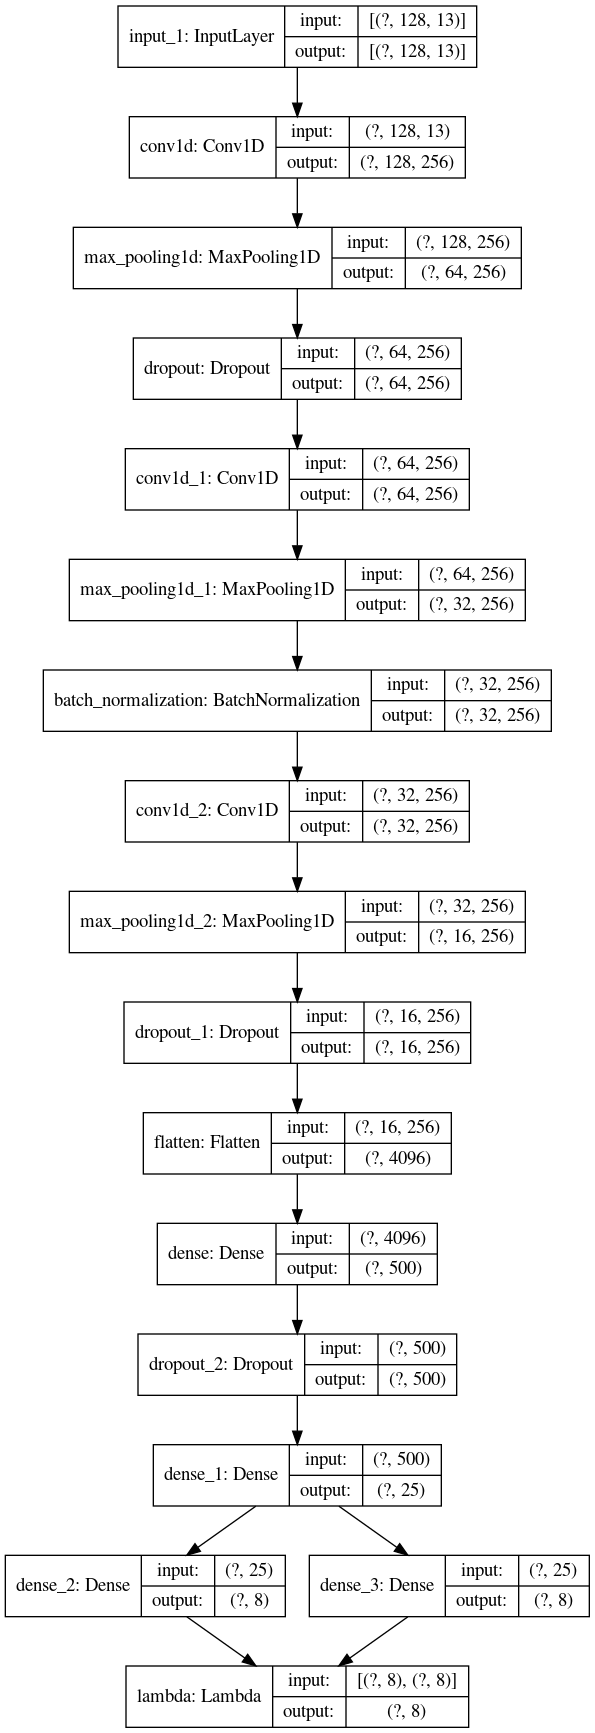

In [9]:
encoder = Model(inputs, [mu, log_var, z], name='encoder')
encoder.summary()
from tensorflow.keras.utils import plot_model

plot_model(encoder, show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 25)                225       
_________________________________________________________________
dense_6 (Dense)              (None, 500)               13000     
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              2052096   
_________________________________________________________________
reshape (Reshape)            (None, 16, 256)           0         
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 32, 256)           0   

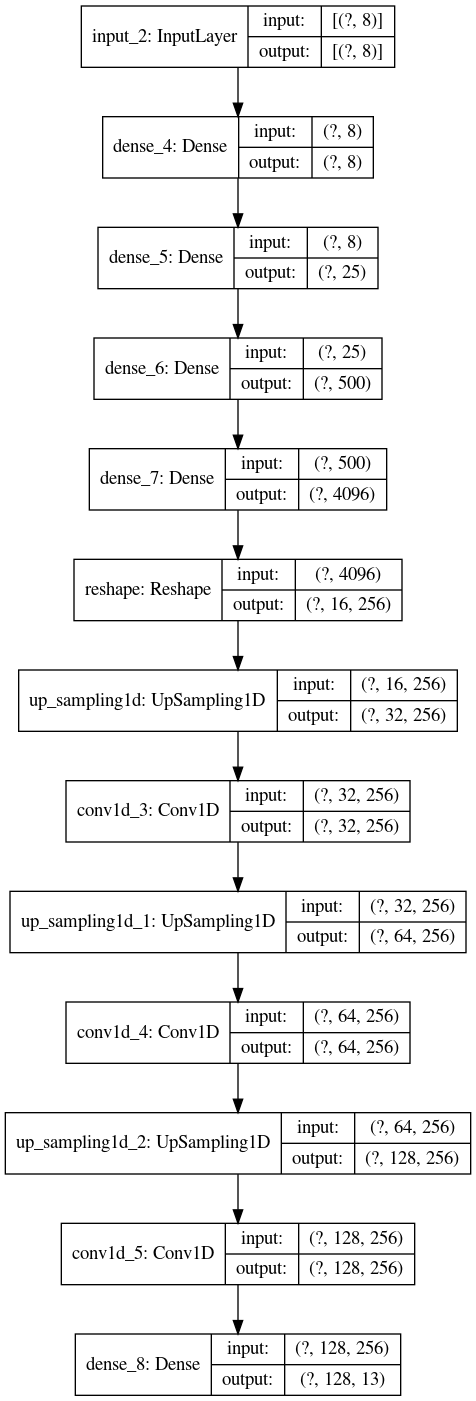

In [10]:
latent_inputs = Input(shape=(z_dim,))
z_decoder = Dense(z_dim, activation='relu')(latent_inputs)
z_decoder = Dense(25, activation='relu')(z_decoder)
z_decoder = Dense(500, activation='relu')(z_decoder)
z_decoder = Dense(int(seq_length/8)*inter_dim, activation='relu')(z_decoder)
z_decoder = Reshape((int(seq_length/8), inter_dim))(z_decoder)
z_decoder = UpSampling1D(2)(z_decoder)
z_decoder = Conv1D(inter_dim,3,padding='same', activation='relu')(z_decoder)
z_decoder = UpSampling1D(2)(z_decoder)
z_decoder = Conv1D(inter_dim,3,padding='same', activation='relu')(z_decoder)
z_decoder = UpSampling1D(2)(z_decoder)
z_decoder = Conv1D(inter_dim,3,padding='same', activation='relu')(z_decoder)
                # No activation
decoder_output = Dense(n_features, activation='relu')(z_decoder)

decoder = Model(latent_inputs, decoder_output, name='decoder')
decoder.summary()
plot_model(decoder, show_shapes=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 13)]         0         
_________________________________________________________________
encoder (Model)              [(None, 8), (None, 8), (N 2466433   
_________________________________________________________________
decoder (Model)              (None, 128, 13)           2659326   
Total params: 5,125,759
Trainable params: 5,125,247
Non-trainable params: 512
_________________________________________________________________


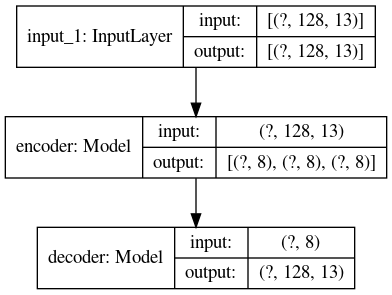

In [11]:
outputs = decoder(encoder(inputs)[2])
# build model
cvae = Model(inputs, outputs)
cvae.summary()
plot_model(cvae, show_shapes=True)

In [12]:
# loss
reconstruction_loss = tf.reduce_mean(binary_crossentropy(inputs, outputs)) * (seq_length*n_features)
kl_loss = 1 + log_var - tf.square(mu) - tf.exp(log_var)
kl_loss = tf.reduce_mean(kl_loss)
kl_loss *= -0.5
total_loss = reconstruction_loss + kl_loss

# build model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
cvae.add_loss(total_loss)
cvae.compile(optimizer='rmsprop')

In [262]:
# train
cvae.fit(X_train,
       shuffle=True,
       epochs=50,
       batch_size=batch_size,
       validation_split=0.3, verbose=1)

Epoch 1/50
244/244 [==============================] - 27s 109ms/step - loss: 49774397468180480.0000 - val_loss: 1145.7410
Epoch 2/50
244/244 [==============================] - 25s 104ms/step - loss: 1495.2528 - val_loss: 1265.6764
Epoch 3/50
244/244 [==============================] - 25s 102ms/step - loss: 1091.4750 - val_loss: 1130.0746
Epoch 4/50
244/244 [==============================] - 25s 101ms/step - loss: 1054.4288 - val_loss: 1054.0830
Epoch 5/50
244/244 [==============================] - 25s 104ms/step - loss: 1040.6121 - val_loss: 1067.2616
Epoch 6/50
244/244 [==============================] - 25s 102ms/step - loss: 1031.4146 - val_loss: 1055.1444
Epoch 7/50
244/244 [==============================] - 26s 105ms/step - loss: 1023.6570 - val_loss: 1012.7095
Epoch 8/50
244/244 [==============================] - 25s 104ms/step - loss: 1019.0709 - val_loss: 1049.9285
Epoch 9/50
244/244 [==============================] - 25s 104ms/step - loss: 1015.9952 - val_loss: 1008.3460
Epoch 

Build slope prediction

In [264]:
encoder.save('encoder.h5')
decoder.save('decoder.h5')
cvae.save('cvae.h5')

In [15]:
from tensorflow.keras.models import load_model

In [16]:
encoder = load_model('encoder.h5')
decoder = load_model('decoder.h5')
cvae = load_model('cvae.h5')

In [ ]:
encoder.predict

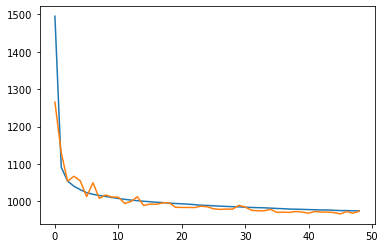

In [263]:
plt.plot(cvae.history.history['loss'][1:])
plt.plot(cvae.history.history['val_loss'][1:])

In [19]:
_,_,mu_z = encoder.predict(X_test, batch_size=512)

In [20]:
mu_z_pdf = pd.DataFrame(mu_z, columns=['LS_%i' % i for i in range(z_dim)])

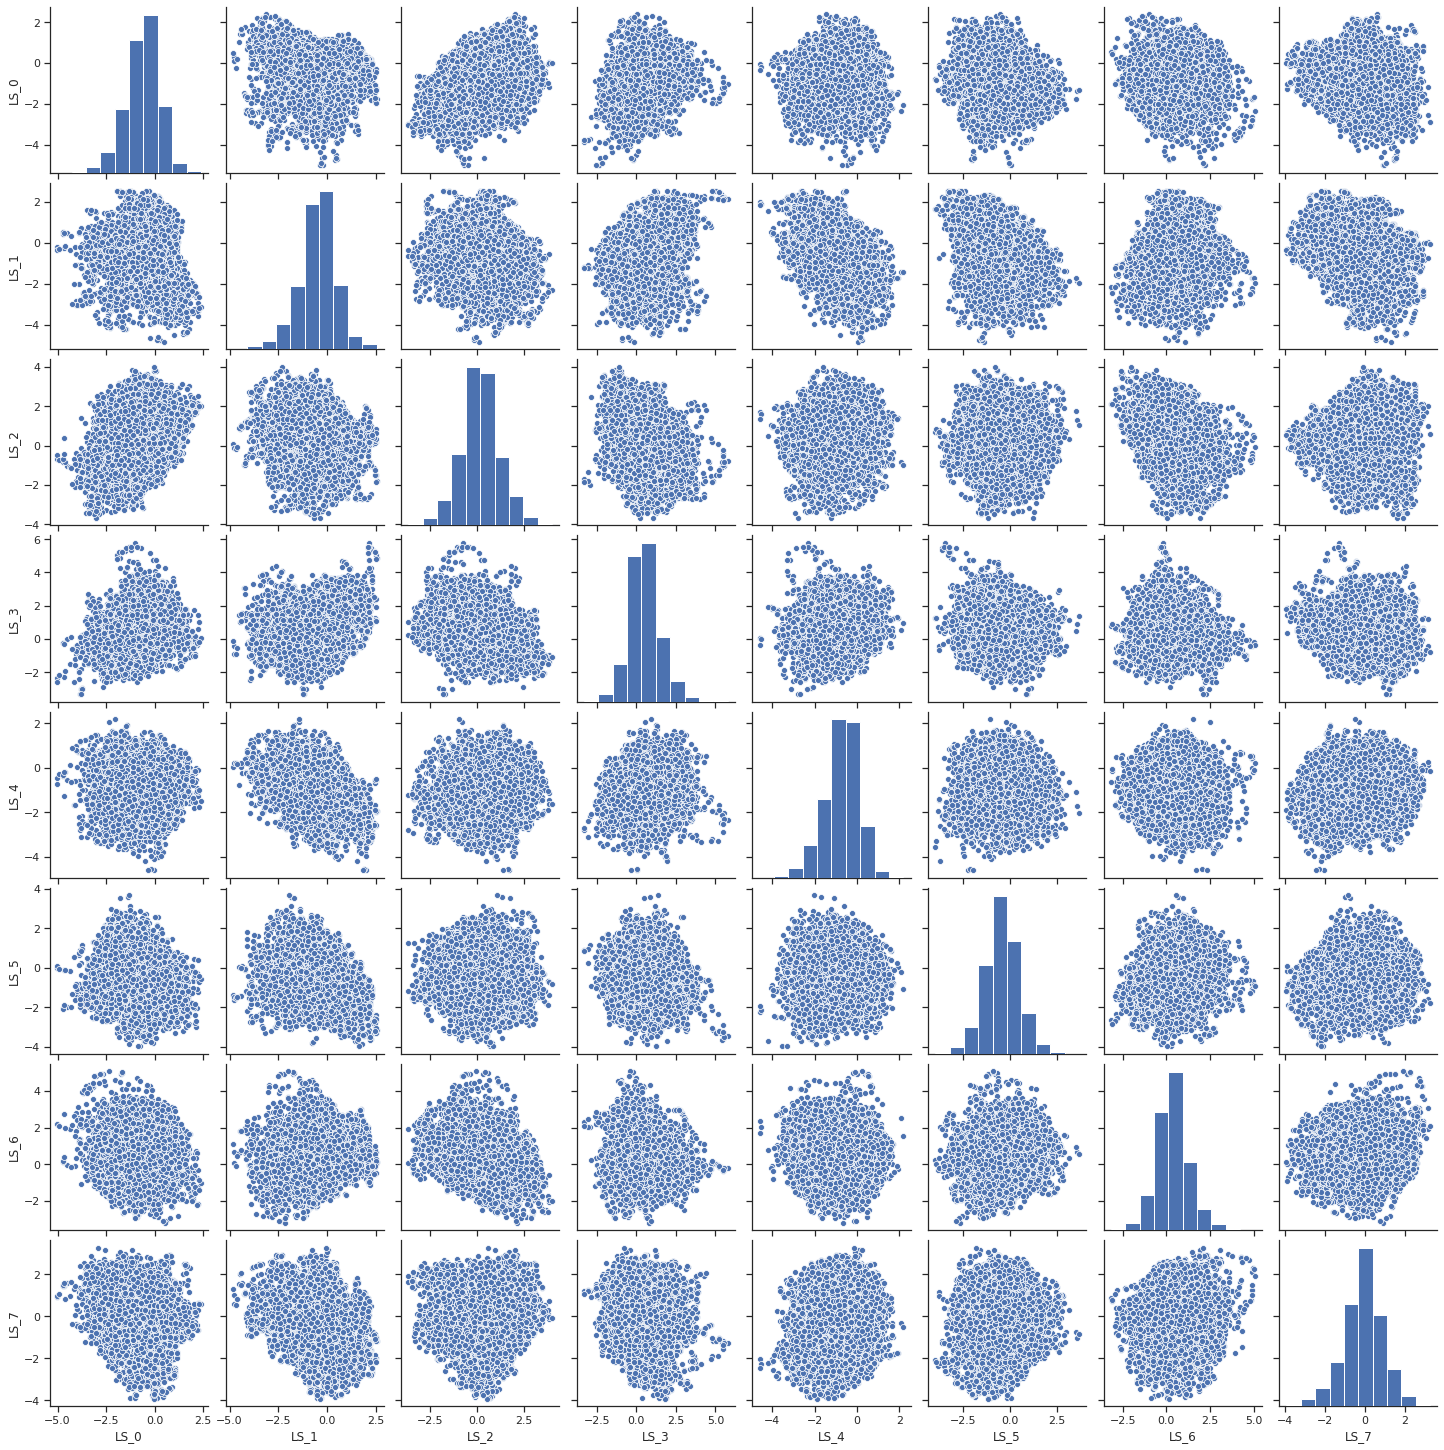

In [22]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.pairplot(mu_z_pdf)

No handles with labels found to put in legend.


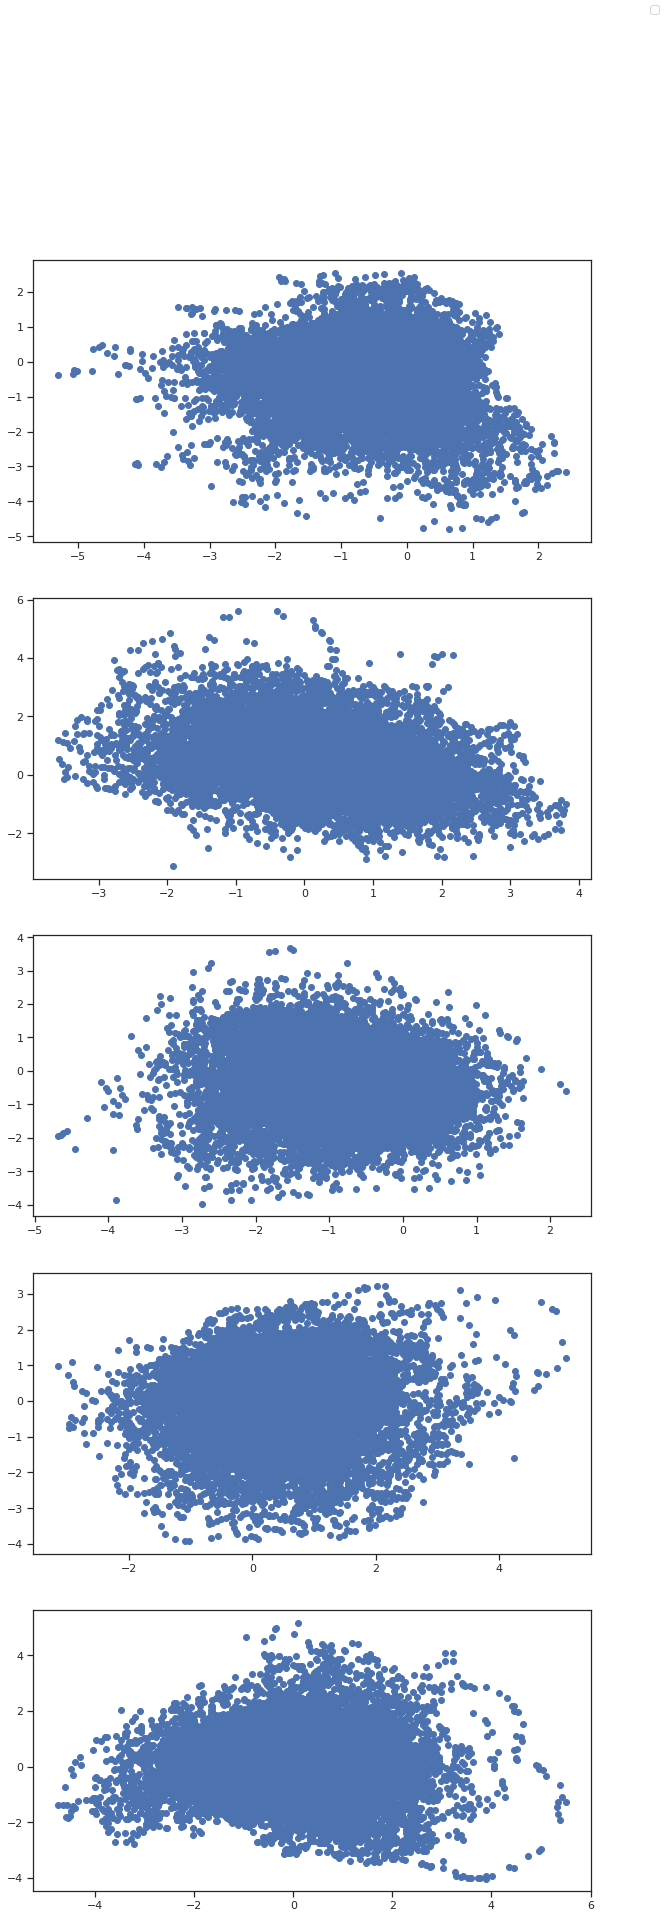

In [267]:
from sklearn.decomposition import PCA
pca = PCA( n_components=2)
pca_comp = pca.fit_transform(mu_z)
fig, axs = plt.subplots(5, figsize=(10,30))
axs[0].scatter(mu_z[:, 0], mu_z[:, 1])
axs[1].scatter(mu_z[:, 2], mu_z[:, 3])
axs[2].scatter(mu_z[:, 4], mu_z[:, 5])
axs[3].scatter(mu_z[:, 6], mu_z[:, 7])
axs[4].scatter(pca_comp[:,0], pca_comp[:,1])
fig.legend()
plt.show()


# New Section

In [268]:
pred = decoder.predict(mu_z[:5])

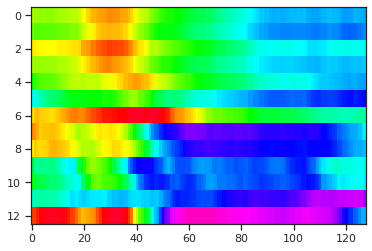

In [269]:
plt.imshow(pred[4].T, aspect='auto', cmap='gist_rainbow', interpolation='nearest')

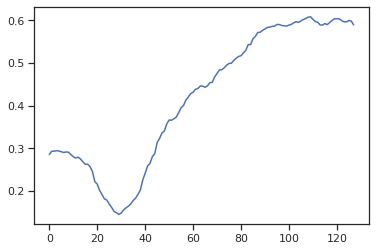

In [270]:
plt.plot(pred[4,:,3])

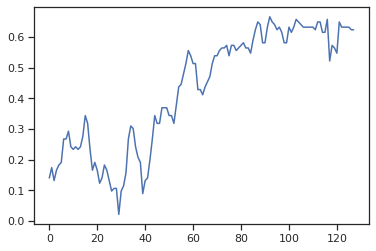

In [271]:
plt.plot(X_test[4,:,3])

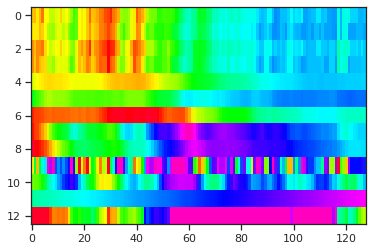

In [273]:
plt.imshow(X_test[4].reshape(128,13).T, aspect='auto', cmap='gist_rainbow', interpolation='nearest')

In [274]:
price_cols = ['Open','High', 'Low', 'Close', 'sma',  'upper_bol', 'lower_bol']
macd_cols = ['macd','macd_signal']
osc_cols = ['per_k_10', 'per_d_10']
non_scaled_cols = ['time','RSI_point8']

all_cols = [price_cols + macd_cols + osc_cols + non_scaled_cols]

In [275]:
_,_,mu_z_train = encoder.predict(X_train, batch_size=512)

B = []
for y_i in Y_train:
  b,_ = np.polyfit(y_i[:8,11], y_i[:8,4], deg=1)
  B.append(b)

In [276]:
_,_,mu_z_test = encoder.predict(X_test, batch_size=512)

B_test = []
for y_i in Y_test:
  b,_ = np.polyfit(y_i[:8,11], y_i[:8,4], deg=1)
  B_test.append(b)

In [277]:
!pip install --upgrade git+https://github.com/stanfordmlgroup/ngboost.git

  Cloning https://github.com/stanfordmlgroup/ngboost.git to /tmp/pip-req-build-6h7zt9mx
  Running command git clone -q https://github.com/stanfordmlgroup/ngboost.git /tmp/pip-req-build-6h7zt9mx
  Created wheel for ngboost: filename=ngboost-0.2.4.dev0-py3-none-any.whl size=38414 sha256=93edffdbed723f281e32ed2616ed5b707f03e5244564167c934b4fd21684eecc
  Stored in directory: /tmp/pip-ephem-wheel-cache-jhbvkwuf/wheels/9a/7f/a2/ce1d8e2bb0b0efd77e813f2311d132f536343daa6c8b5a81ee
Successfully built ngboost
  Attempting uninstall: ngboost
    Found existing installation: ngboost 0.2.4.dev0
    Uninstalling ngboost-0.2.4.dev0:
      Successfully uninstalled ngboost-0.2.4.dev0


In [278]:
from ngboost import NGBRegressor

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


ngb = NGBRegressor(n_estimators=3000, learning_rate=0.01).fit(mu_z_train, np.array(B),X_val=mu_z_test, Y_val=np.array(B_test))
Y_preds = ngb.predict(mu_z_test)
Y_dists = ngb.pred_dist(mu_z_test)

# test Mean Squared Error
test_MSE = mean_squared_error(Y_preds, np.array(B_test))
print('Test MSE', test_MSE)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(np.array(B_test)).mean()
print('Test NLL', test_NLL)

[iter 0] loss=2.1375 val_loss=2.1355 scale=1.0000 norm=1.6809
[iter 100] loss=2.0070 val_loss=2.0130 scale=1.0000 norm=1.5577
[iter 200] loss=1.9612 val_loss=1.9712 scale=1.0000 norm=1.5307
[iter 300] loss=1.9377 val_loss=1.9507 scale=1.0000 norm=1.5195
[iter 400] loss=1.9224 val_loss=1.9376 scale=1.0000 norm=1.5110
[iter 500] loss=1.9124 val_loss=1.9296 scale=1.0000 norm=1.5053
[iter 600] loss=1.9037 val_loss=1.9226 scale=1.0000 norm=1.4999
[iter 700] loss=1.8963 val_loss=1.9165 scale=1.0000 norm=1.4949
[iter 800] loss=1.8906 val_loss=1.9120 scale=2.0000 norm=2.9816
[iter 900] loss=1.8843 val_loss=1.9073 scale=1.0000 norm=1.4862
[iter 1000] loss=1.8795 val_loss=1.9038 scale=1.0000 norm=1.4826
[iter 1100] loss=1.8751 val_loss=1.9007 scale=1.0000 norm=1.4794
[iter 1200] loss=1.8706 val_loss=1.8974 scale=1.0000 norm=1.4759
[iter 1300] loss=1.8660 val_loss=1.8941 scale=1.0000 norm=1.4723
[iter 1400] loss=1.8617 val_loss=1.8910 scale=1.0000 norm=1.4691
[iter 1500] loss=1.8576 val_loss=1.88

In [295]:
from ngboost.evaluation import *
pctles, observed, slope, intercept = calibration_regression(Y_dists, mu_z_test-min(mu_z_test)+0.001)
plt.subplot(1, 2, 1)
plot_pit_histogram(pctles, observed, label="MSE", linestyle = "-")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [279]:
pickle.dump(ngb, open('ngboost.pkl', 'wb'))

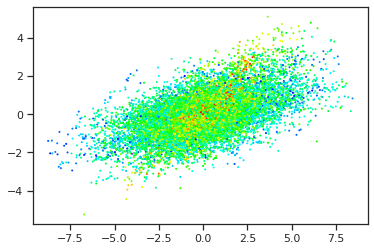

In [280]:
plt.scatter(np.array(B_test),Y_preds,cmap='gist_rainbow', c=Y_dists.scale, s=1)

In [281]:
tick = 'GBPJPY=X'
pred_data = curDict[tick]

In [282]:
pred_data = pred_data

In [283]:

preds = []
idxs = []
probs = []
dts = []
obs_pred = []
for i in range(len(pred_data)-(seq_length)):
    obs = pred_data.iloc[i:i+seq_length]
    if len(obs) == seq_length:
        price_obs = obs[price_cols].values
        price_obs = (price_obs - price_obs.min())/(price_obs.max()-price_obs.min())
        macd_obs = obs[macd_cols].values
        macd_obs = (macd_obs - macd_obs.min())/(macd_obs.max()-macd_obs.min())
        osc_obs = obs[osc_cols].values
        osc_obs = (osc_obs - osc_obs.min())/(osc_obs.max()-osc_obs.min())
        other_obs = obs[non_scaled_cols].values
        obs_pp = np.concatenate([price_obs, macd_obs,osc_obs,other_obs], axis=1)
        obs_pred.append(obs_pp)
        idxs.append([i,i+seq_length,i+seq_length+8])
        dts.append(obs.index[-1])

_,_,z = encoder.predict(np.array(obs_pred), batch_size=64)
preds = (ngb.predict(z))
probs = (ngb.pred_dist(z).scale)
predDict = {'prob': probs,'pred':preds, 'idx':idxs, 'times':dts}
gbpyn = pd.DataFrame(predDict)
gbpyn.index = pd.DatetimeIndex(gbpyn['times'])
results = gbpyn_df.join(gbpyn)
gbpyn_df = curDict[tick]

100%|██████████| 2684/2684 [00:10<00:00, 255.61it/s]


In [284]:
np.array(obs_pred).shape

(2678, 136, 13)

In [285]:
np.array(obs_pred)[:,:-8,:].shape

(2678, 128, 13)

In [286]:
_,_,z = encoder.predict(np.array(obs_pred), batch_size=64)
preds = (ngb.predict(z))
probs = (ngb.pred_dist(z).scale)
predDict = {'prob': probs,'pred':preds, 'idx':idxs, 'times':dts}


In [287]:
gbpyn = pd.DataFrame(predDict)

In [288]:
gbpyn.index = pd.DatetimeIndex(gbpyn['times'])

In [289]:
gbpyn_df = curDict[tick]

In [290]:
results = gbpyn_df.join(gbpyn)

In [291]:
results.columns

Index(['Open', 'High', 'Low', 'Close', 'time', 'sma', 'per_k_10', 'per_d_10',
       'macd', 'macd_signal', 'upper_bol', 'lower_bol', 'RSI_point8', 'prob',
       'pred', 'idx', 'times'],
      dtype='object')

In [292]:
results.head(300)

Open     High      Low    Close      time  \
Datetime                                                                  
2020-08-03 01:35:00+01:00  138.945  139.028  138.900  138.929  0.065972   
2020-08-03 01:40:00+01:00  138.930  138.949  138.850  138.913  0.069444   
2020-08-03 01:45:00+01:00  138.912  138.946  138.790  138.835  0.072917   
2020-08-03 01:50:00+01:00  138.836  138.873  138.730  138.765  0.076389   
2020-08-03 01:55:00+01:00  138.765  138.841  138.730  138.794  0.079861   
...                            ...      ...      ...      ...       ...   
2020-08-04 03:05:00+01:00  138.817  138.827  138.760  138.817  0.128472   
2020-08-04 03:10:00+01:00  138.821  138.882  138.780  138.862  0.131944   
2020-08-04 03:15:00+01:00  138.860  138.883  138.786  138.824  0.135417   
2020-08-04 03:20:00+01:00  138.822  138.832  138.760  138.786  0.138889   
2020-08-04 03:25:00+01:00  138.787  138.831  138.740  138.808  0.142361   

                                 sma  per_k_10  per_d_10      macd  \
Datetime                                                             
2020-08-03 01:35:00+01:00  138.65425  0.797131  0.700740  0.054096   
2020-08-03 01:40:00+01:00  138.66910  0.764344  0.677175  0.064983   
2020-08-03 01:45:00+01:00  138.68020  0.604508  0.653523  0.066550   
2020-08-03 01:50:00+01:00  138.68830  0.461066  0.627322  0.061436   
2020-08-03 01:55:00+01:00  138.69915  0.520492  0.634756  0.059042   
...                              ...       ...       ...       ...   
2020-08-04 03:05:00+01:00  138.73225  0.943503  0.875315  0.047588   
2020-08-04 03:10:00+01:00  138.74265  0.913793  0.879868  0.051342   
2020-08-04 03:15:00+01:00  138.75015  0.746781  0.872832  0.050667   
2020-08-04 03:20:00+01:00  138.75695  0.445714  0.830169  0.046529   
2020-08-04 03:25:00+01:00  138.76470  0.486301  0.780927  0.044512   

                           macd_signal   upper_bol   lower_bol  RSI_point8  \
Datetime                                                                     
2020-08-03 01:35:00+01:00     0.019188  138.873446  138.435054    0.728886   
2020-08-03 01:40:00+01:00     0.028347  138.915891  138.422309    0.749406   
2020-08-03 01:45:00+01:00     0.035987  138.936166  138.424234    0.708582   
2020-08-03 01:50:00+01:00     0.041077  138.944233  138.432367    0.664745   
2020-08-03 01:55:00+01:00     0.044670  138.953610  138.444690    0.709090   
...                                ...         ...         ...         ...   
2020-08-04 03:05:00+01:00     0.043134  138.847529  138.616971    1.000000   
2020-08-04 03:10:00+01:00     0.044776  138.865487  138.619813    1.000000   
2020-08-04 03:15:00+01:00     0.045954  138.873654  138.626646    1.000000   
2020-08-04 03:20:00+01:00     0.046069  138.871917  138.641983    1.000000   
2020-08-04 03:25:00+01:00     0.045758  138.870711  138.658689    1.000000   

                               prob      pred              idx  \
Datetime                                                         
2020-08-03 01:35:00+01:00       NaN       NaN              NaN   
2020-08-03 01:40:00+01:00       NaN       NaN              NaN   
2020-08-03 01:45:00+01:00       NaN       NaN              NaN   
2020-08-03 01:50:00+01:00       NaN       NaN              NaN   
2020-08-03 01:55:00+01:00       NaN       NaN              NaN   
...                             ...       ...              ...   
2020-08-04 03:05:00+01:00  1.225147  1.006993  [167, 295, 303]   
2020-08-04 03:10:00+01:00  1.225147  0.989430  [168, 296, 304]   
2020-08-04 03:15:00+01:00  1.222401  0.971551  [169, 297, 305]   
2020-08-04 03:20:00+01:00  1.338835  0.971551  [170, 298, 306]   
2020-08-04 03:25:00+01:00  1.367311  0.797841  [171, 299, 307]   

                                              times  
Datetime                                             
2020-08-03 01:35:00+01:00                       NaT  
2020-08-03 01:40:00+01:00                       NaT  
2020-08-03 01:45:00+01:00                       NaT  

In [81]:
!pip install plotly


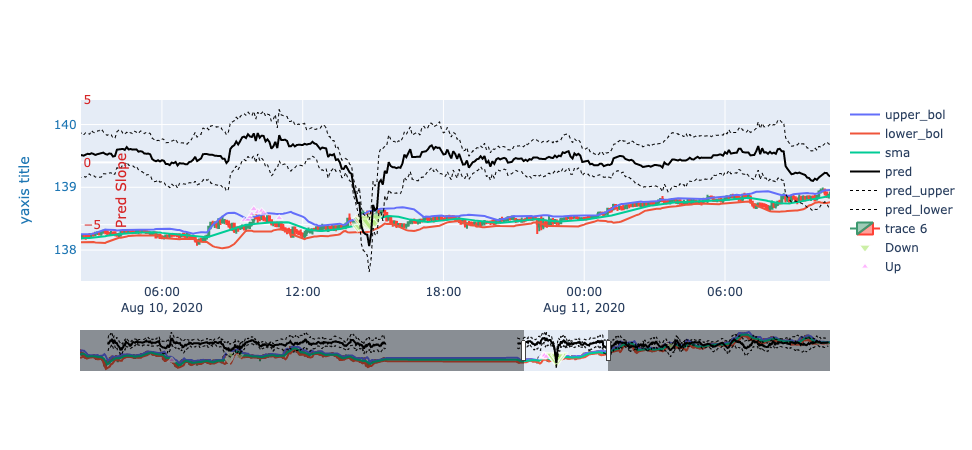

In [313]:
import plotly.graph_objects as go

threshold = 0.6
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=results.index,
    y=results['upper_bol'],
    name="upper_bol",
    mode='lines'

))

fig.add_trace(go.Scatter(
    x=results.index,
    y=results['lower_bol'],
    name="lower_bol",
    mode='lines'
))

fig.add_trace(go.Scatter(
    x=results.index,
    y=results['sma'],
    name="sma",
    mode='lines'
))

fig.add_trace(go.Scatter(
    x=results.index,
    y=results['pred'],
    name="pred",
    line = dict(color='black', width=2),
    yaxis="y2"
))


fig.add_trace(go.Scatter(
    x=results.index,
    y=results['pred']+results['prob'],
    name="pred_upper",
    line = dict(color='black', width=1, dash='dot'),
    yaxis="y2"
))
fig.add_trace(go.Scatter(
    x=results.index,
    y=results['pred']-results['prob'],
    name="pred_lower",
    line = dict(color='black', width=1, dash='dot'),
    yaxis="y2"
))
# Add traces
fig.add_trace(go.Candlestick(x=results.index,
                open=results['Open'],
                high=results['High'],
                low=results['Low'],
                close=results['Close']))
fig.add_trace(go.Scatter(x=results[(results['pred']<-2)].index,
                         y=results[(results['pred']<-2)]['Close']-0.1,
                    mode='markers',
                    name='Down',
                    marker=dict(
                        size=abs(results[results['pred']<-2]['pred'])*3
                    ),
                        marker_symbol='triangle-down'))
fig.add_trace(go.Scatter(x=results[(results['pred']>2)].index,
                         y=results[(results['pred']>2)]['Close']+0.1,
                    mode='markers',
                    name='Up',
                    marker=dict(
                        size=results[results['pred']>2]['pred']*3
                    ),
                        marker_symbol='triangle-up'))

fig.update_layout(

    yaxis=dict(
        title="yaxis title",
        titlefont=dict(
            color="#1f77b4"
        ),
        tickfont=dict(
            color="#1f77b4"
        )
    ),
    yaxis2=dict(
        title="Pred Slope",
        titlefont=dict(
            color="#d62728"
        ),
        tickfont=dict(
            color="#d62728"
        ),
        anchor="free",
        overlaying="y",
        side="right"
    ))



fig.show()